**<center><font size=5>EEG Data Analysis and Machine Learning(SVM)</font></center>**
***<center>Alcoholic vs Control Groups</center>***
***
**Autor**: Iván García Alvarez

**Fecha**: 23 Marzo del 2019

**[GitHub Repository](https://github.com/navi931/EEG-alcohol)**

#### Table of Contents
- <a href='#intro'>1. Project Overview</a> 
- <a href='#env'>2. Setting up the Environment</a>
- <a href='#import'>2.1. Data Import</a>
- <a href='#Preprocessing'>5. Preprocessing</a>
- <a href='#Training'>5. Training</a> 
- <a href='#Testing'>5. Testing</a> 
- <a href='#Conclusiones'>5. Conclusiones</a>

# <a id='intro'>1.Project Overview</a>

Este proyecto ha sido publicado en Kaggle [EEG-Alcohol](https://www.kaggle.com/ruslankl/eeg-data-analysis) como un reto para implementar Machine Learning, así que hemos tomado el reto y en este proyecto implementaremos Support Vector Machines.Al igual que el estudio de kaggle he escogido el [EEG-Alcohol](https://www.kaggle.com/nnair25/Alcoholics) dataset, el cual [EEG (Electroencephalography)](https://en.wikipedia.org/wiki/Electroencephalography) que son los datos de dos grupos - Alcoholic and Control Group. 
![](https://i.imgur.com/ZrmxJRu.jpg)
La cantidad de sujetos en cada grupo es 8. Los 64 electrodos se colocaron en el cuero cabelludo del sujeto para medir la actividad eléctrica del cerebro. Los valores de respuesta se muestrearon a 256 Hz (época de 3.9 ms) durante 1 segundo. Cada sujeto fue expuesto a un solo estímulo (S1) o a dos estímulos (S1 y S2) que eran imágenes de objetos elegidos de entre [1980 Snodgrass and Vanderwart picture set](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.294.1979&rep=rep1&type=pdf). Cuando se mostraron dos estímulos, se presentaron en una condición emparejada donde S1 era idéntico a S2 o en una condición no emparejada donde S1 difería de S2.

El propósito del algoritmo será detectar diferencias entre los valores de respuesta para diferentes estímulos entre el control y el grupo alcohólico.

# <a id='env'>2. Setting up the Environment</a>
## <a id='import'>2.1. Data Import</a>

In [1]:
import numpy as np
import pandas as pd
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from sklearn.svm import LinearSVC
from tqdm import tqdm_notebook as tqdm
import os
import warnings
import random
import scikitplot as skplt
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import numpy as np
from matplotlib import pyplot as plt
warnings.filterwarnings("ignore")
%matplotlib inline 

# <a id='Preprocessing'>Preprocessing</a>
Lo primero que haremos será hacer el preprcesamiento de los datos, tomaremos en cuenta las siguientes recomendaciones para esto:
* No nos interesa un "id" del sujeto, pues puede ocasionar un overfitting

* Nos interesa mucho cuales sensores son los sensores importantes, para esto tomaremos las conclusiones dadas por el estudio previo que son 'FPZ', 'FP2', 'AF3', 'AFZ', 'AF4', 'F5', 'F3', 'F1', 'FZ', 'FC5', 'FC3', 'FCZ', 'T7', 'CZ', 'C4', 'C6','TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP8', 'P5', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO4', 'O1'

* Analizando los datos nos dimos cuenta que la posicion del sensor y el canal, es lo mismo entonces por motivos de procesamiento hemos decidir eliminar el campo chanel.

* Para un mejor rendimiento del algoritmo se ha decidido dejar todo en valores númericos

Enseguida procederemos a obtener los datos y cargarlos a python

In [2]:
eeg_data_S1Obj = pd.read_csv("eeg_datasets_split/eeg_data_S1Obj.csv",encoding='latin-1')
eeg_data_S2Match = pd.read_csv("eeg_datasets_split/eeg_data_S2Match.csv",encoding='latin-1')
eeg_data_S2NoMatch = pd.read_csv("eeg_datasets_split/eeg_data_S2NoMatch.csv",encoding='latin-1')
eeg_data = [eeg_data_S1Obj,eeg_data_S2Match,eeg_data_S2NoMatch]
eeg_data_S1Obj.head(n=10)

,Target,d0,d1,d2,d3,d4,d5,d6,d7,d8,...,d8438,d8439,d8440,d8441,d8442,d8443,d8444,d8445,d8446,d8447
0,c,0.081,0.824,4.364,4.842,3.703,1.200,4.323,5.117,4.201,...,-8.586,-9.206,-10.030,-12.726,-7.284,-5.259,-5.208,2.218,-7.324,-7.853
1,a,-0.214,-4.639,-5.066,-5.910,-5.188,-2.787,-5.147,-6.856,-6.124,...,-3.998,-6.571,-3.988,13.234,-1.119,-1.740,-7.517,-0.753,34.576,-7.111
2,c,-2.757,-0.590,-1.149,0.397,0.285,-4.720,-2.309,0.387,0.763,...,-17.192,-24.638,-13.855,-18.250,-12.421,-11.688,-10.142,-5.514,-7.314,-10.579
3,c,0.051,-2.838,2.523,0.987,-1.648,3.042,3.550,1.984,-0.153,...,0.407,6.022,5.219,2.736,6.276,6.683,6.165,2.024,1.373,3.184
4,c,4.883,7.945,3.957,4.842,4.771,3.245,2.686,2.553,2.472,...,-20.182,-23.448,-2.604,-15.940,-24.424,-25.645,-25.981,-20.579,-20.691,-24.506
5,c,4.822,6.521,0.366,1.119,2.411,-1.068,-0.804,-0.437,-0.173,...,-3.754,-5.941,-1.414,-2.116,0.051,-4.852,-2.574,9.288,-3.560,-8.006
6,a,-3.540,-8.840,-2.340,-3.448,-5.422,0.275,-1.343,-2.950,-2.309,...,-1.892,-2.706,-2.950,-13.763,-0.621,-0.478,0.814,5.636,-2.696,-3.092
7,c,-4.730,-4.547,-4.140,-2.635,-2.543,-3.042,-1.302,-1.373,-0.610,...,-2.502,-3.855,-3.520,-4.761,-7.701,-4.120,-3.276,-4.517,-3.194,-2.767
8,c,-0.193,-0.783,2.401,4.751,4.781,-4.445,-1.495,2.869,6.419,...,2.858,7.741,8.881,7.334,4.791,2.370,4.801,16.093,-0.264,7.477
9,a,-5.554,-7.955,-4.761,-6.104,-7.192,-2.513,-3.581,-6.429,-3.998,...,-12.950,-3.438,-6.093,-13.540,-8.769,-15.544,-11.149,-11.739,10.193,-15.096


Enseguida revisaremos los datos para checar la distribucion de alcoholicos

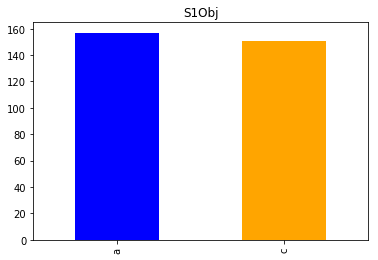

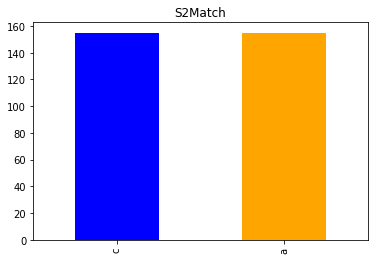

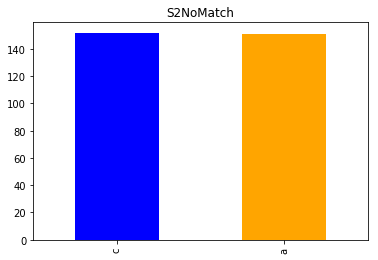

In [3]:
count_Class=pd.value_counts(eeg_data_S1Obj["Target"])
count_Class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('S1Obj')
plt.show()
count_Class=pd.value_counts(eeg_data_S2Match["Target"])
count_Class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('S2Match')
plt.show()
count_Class=pd.value_counts(eeg_data_S2NoMatch["Target"])
count_Class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('S2NoMatch')
plt.show()

Como vemos la distribucion es muy ideal, pues estan casi al 50% de alcholicos

Enseguida lo que haremos sera clasificar los alcoholicos 'a' como 1 y grupo de control como 0 (campo a clasificar)
además que solo usaremos los campos "sensor_position","sample_num","sensor_value","matching_condition".

In [4]:
X = [0,1,2]
Y = [0,1,2]
index = 0
for data in tqdm(eeg_data):
    data["Target"]= data["Target"].map({'a':1,'c':0})
    Y[index] = np.array(data["Target"])
    data = np.array(data)
    X[index] = np.delete((np.array(data)), 0, 1)
    index = index + 1;

X_train_s1, X_test_s1, y_train_s1, y_test_s1 = model_selection.train_test_split(X[0],Y[0], test_size=0.25, random_state=42)
X_train_s2_match, X_test_s2_match, y_train_s2_match, y_test_s2_match = model_selection.train_test_split(X[1],Y[1],test_size=0.25, random_state=42)
X_train_s2_no_match, X_test_s2_no_match, y_train_s2_no_match, y_test_s2_no_match = model_selection.train_test_split(X[2],Y[2],test_size=0.25, random_state=42)


##### En la siguientes lineas extremaremos los datos, para que el algoritmo pueda identificar con mayor precision un alcoholico a un no alcoholico

In [5]:
trains = [X_train_s1,X_train_s2_match,X_train_s2_no_match,X_test_s1,X_test_s2_match,X_test_s2_no_match]
for train in tqdm(trains):
    for prueba in train:
        i = 0
        while(i<len(prueba)):
                prueba[i] = prueba[i]*100
                i = i + 1
print(X_train_s1)


[[  436.4  1034.5   651.  ...  2762.9   420.1   912.5]
 [ -355.   -419.1  -352.  ...  1528.9   470.   1108.8]
 [ -393.7  -447.6  -608.3 ... -3465.8   -99.7  -320.4]
 ...
 [  212.6   129.2  -100.7 ...  -705.   -878.9  -434.4]
 [  483.2   447.6   712.1 ... -1316.3 -1089.5  -738.5]
 [  830.1   879.9   654.1 ...  1085.4   197.3  -260.4]]


Al igual despues checaremos como se veria una imagen con estos datos

No alcoholico
Alcoholico
Alcoholico
No alcoholico
Alcoholico


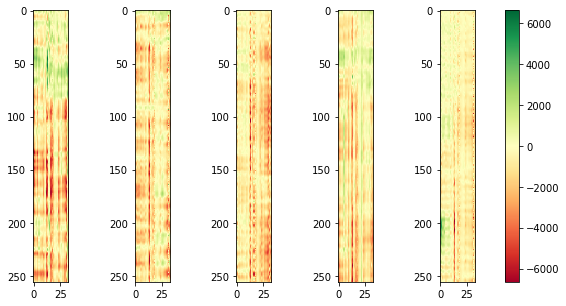

In [6]:
for y in y_train_s2_no_match[5:10]:
    print('Alcoholico' if (y == 1) else 'No alcoholico')

def show_as_images(samples):
    h, w = 10, 20        # for raster image
    figsize = [11, 5]     # figure size, inches
    ncols = 5
    nrows = 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    for idx, sample in enumerate(samples):
        bitmap = sample.reshape(256, -1)
        maxval = np.max(np.abs([bitmap.min(),bitmap.max()]))
        rowid = i // ncols
        colid = 0
        img = axes.flat[idx].imshow(bitmap, cmap='RdYlGn', interpolation='nearest',vmin=-maxval, vmax=maxval)
    
    plt.colorbar(img, ax=axes.ravel().tolist())
    plt.show()
show_as_images(X_train_s2_no_match[5:10])

Observamos que una imagen, a simple vista no es muy facil de diferenciar si es alcoholico o no

# <a id='Training'>Training</a>
Teniendo los datasets de train y de prueba procederemos a entrenar el modelo.

In [7]:
svc = LinearSVC(random_state=0, tol=1e-5)
svc.fit(X_train_s1, y_train_s1)

svc2 = LinearSVC(random_state=0, tol=1e-5)
svc2.fit(X_train_s2_match, y_train_s2_match)

svc3 = LinearSVC(random_state=0, tol=1e-5)
svc3.fit(X_train_s2_no_match, y_train_s2_no_match)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=1e-05, verbose=0)

# <a id='Testing'>Testing</a>
Ya entrenado el modelo procederemos a medir diferentes mediciones 
como el accuracy,precision,recall y la matriz de confusion

Modelo de SVMs1

                     Predicted no alcoholic  Predicted alcoholic
Actual no alcoholic                      34                    5
Actual alcoholic                         15                   23
Accuracy 0.7402597402597403
recall 0.6052631578947368
precision 0.8214285714285714



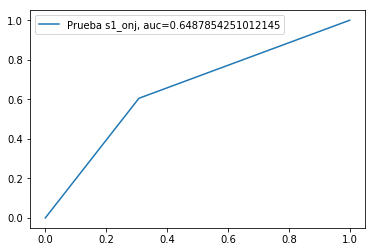

In [8]:
print("Modelo de SVMs1")
print("")
m_confusion_test_svm = metrics.confusion_matrix(y_test_s1, svc.predict(X_test_s1))
print(pd.DataFrame(data = m_confusion_test_svm, columns = ['Predicted no alcoholic', 'Predicted alcoholic'],
            index = ['Actual no alcoholic', 'Actual alcoholic']))

print("Accuracy",svc.score(X_test_s1, y_test_s1))
print("recall",metrics.recall_score(y_test_s1, svc.predict(X_test_s1)))
print("precision",metrics.precision_score(y_test_s1, svc.predict(X_test_s1)))
print("")
y_true = y_test_s1  # ground truth labels
y_probas = svc2.predict(X_test_s1) # predicted probabilities generated by sklearn classifier

fpr, tpr, _ = metrics.roc_curve(y_true,  y_probas)
auc = metrics.roc_auc_score(y_true, y_probas)
plt.plot(fpr,tpr,label="Prueba s1_onj, auc="+str(auc))
plt.legend()
plt.show()

Segundo modelo

Modelo de SVMs2

                     Predicted no alcoholic  Predicted alcoholic
Actual no alcoholic                      24                   14
Actual alcoholic                          9                   31
Accuracy 0.7051282051282052
recall 0.775
precision 0.6888888888888889



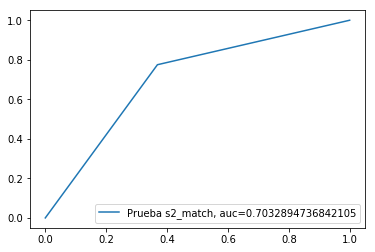

In [9]:
print("Modelo de SVMs2")
print("")
m_confusion_test_svm2 = metrics.confusion_matrix(y_test_s2_match, svc2.predict(X_test_s2_match))
print(pd.DataFrame(data = m_confusion_test_svm2, columns = ['Predicted no alcoholic', 'Predicted alcoholic'],
            index = ['Actual no alcoholic', 'Actual alcoholic']))

print("Accuracy",svc2.score(X_test_s2_match, y_test_s2_match))
print("recall",metrics.recall_score(y_test_s2_match, svc2.predict(X_test_s2_match)))
print("precision",metrics.precision_score(y_test_s2_match, svc2.predict(X_test_s2_match)))
print("")
y_true = y_test_s2_match  # ground truth labels
y_probas = svc2.predict(X_test_s2_match) # predicted probabilities generated by sklearn classifier

fpr, tpr, _ = metrics.roc_curve(y_true,  y_probas)
auc = metrics.roc_auc_score(y_true, y_probas)
plt.plot(fpr,tpr,label="Prueba s2_match, auc="+str(auc))
plt.legend()
plt.show()

Tercer modelo

Modelo de SVMs3

                     Predicted no alcoholic  Predicted alcoholic
Actual no alcoholic                      27                    9
Actual alcoholic                          4                   36
Accuracy 0.8289473684210527
recall 0.9
precision 0.8



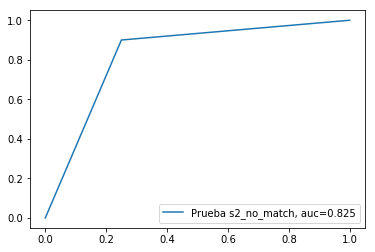

In [10]:
print("Modelo de SVMs3")
print("")
m_confusion_test_svm3 = metrics.confusion_matrix(y_test_s2_no_match, svc3.predict(X_test_s2_no_match))
print(pd.DataFrame(data = m_confusion_test_svm3, columns = ['Predicted no alcoholic', 'Predicted alcoholic'],
            index = ['Actual no alcoholic', 'Actual alcoholic']))

print("Accuracy",svc3.score(X_test_s2_no_match, y_test_s2_no_match))
print("recall",metrics.recall_score(y_test_s2_no_match, svc3.predict(X_test_s2_no_match)))
print("precision",metrics.precision_score(y_test_s2_no_match, svc3.predict(X_test_s2_no_match)))
print("")


y_true = y_test_s2_no_match  # ground truth labels
y_probas = svc3.predict(X_test_s2_no_match) # predicted probabilities generated by sklearn classifier

fpr, tpr, _ = metrics.roc_curve(y_true,  y_probas)
auc = metrics.roc_auc_score(y_true, y_probas)
plt.plot(fpr,tpr,label="Prueba s2_no_match, auc="+str(auc))
plt.legend()
plt.show()

# <a id='Pruebas personales'>Pruebas personales</a>
Teniendo el modelo entrenado veremos como clasifica ciertas personas random.
Tomaremos a 3 personas, una para cada clasificador, y veremos como las clasifica.

In [11]:
modelos = [svc,svc2,svc3]
aleatorio = random.randint(0, 50)
test = [0,0,0]
diagnosticos = [0,0,0]
test[0] = X_test_s1
test[1] = X_test_s2_match
test[2] = X_test_s2_no_match
diagnosticos[0] = y_test_s1[aleatorio]
diagnosticos[1] = y_test_s2_match[aleatorio]
diagnosticos[2] = y_test_s2_no_match[aleatorio]
# 'alcoholico' if (modelo.predict(test[index])[aleatorio]==1) else 'no alcoholico'
# 'alcoholico' if (diagnosticos[index][aleatorio]==1) else 'no alcoholico'
index = 0

predicts = [0,0,0]

for modelo in modelos:
    predicts[index] = modelo.predict(test[index])[aleatorio]
    index = index + 1
    
index = 0
for modelo in modelos:
    print('El algoritmo dijo que','si es alcoholico' if (predicts[index]==1) else 'no es alcoholico',
          'y en realidad','si es alcoholico' if (diagnosticos[index]==1) else 'no es alcoholico')
    index = index + 1

El algoritmo dijo que si es alcoholico y en realidad no es alcoholico
El algoritmo dijo que si es alcoholico y en realidad si es alcoholico
El algoritmo dijo que si es alcoholico y en realidad no es alcoholico


# <a id='Conclusiones'>Conclusiones</a>
Si utilizamos solo el 3er clasificador tendremos mejores resultados, pues es el que tiene mejores resultados de testing, esa es la prueba mas contundente para clasificar a alguien como alcoholico o no.